# 演習III 第４回 ツイッターテキスト解析

出典：https://qiita.com/e10persona/items/7a7643b266c2bdfbf7d0

Google Colab 用

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7

必要なライブラリのインストール

In [1]:
!pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org tweepy mecab-python3 wordcloud oseti

ライブラリのインポートを行います。

In [375]:
import tweepy
import MeCab
import csv
import json
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import oseti
import collections

証明書関係エラー防止

In [3]:
import os
os.environ['CURL_CA_BUNDLE'] = ''
warnings.simplefilter('ignore')

## MeCab のテスト

※ MeCab は別途インストールしておくこと

In [4]:
mecab = MeCab.Tagger("-Ochasen") 
malist = mecab.parse("すもももももももものうち")
print(malist)

すもも	スモモ	すもも	名詞-一般		
も	モ	も	助詞-係助詞		
もも	モモ	もも	名詞-一般		
も	モ	も	助詞-係助詞		
もも	モモ	もも	名詞-一般		
の	ノ	の	助詞-連体化		
うち	ウチ	うち	名詞-非自立-副詞可能		
EOS



## Tweet の取得

In [5]:
CK = 'X6CkomphPSRlb3FyZDJrYU0Z2'                             # Consumer Key
CS = 'VTT4d6vARlrMM90RRrWrqWH9IALSccLUltiGx0v4WA6O9uVnS1'    # Consumer Secret
AT = '5710242-20WdXf5snVQuOThPNEK7KaoYDdhNHodZ57TlcICFuF'    # Access Token
AS = 'jLIt16Pl7hGqv7iRsNnrD7eFTXHJxfPYHIHjpkjhog3oX'         # Accesss Token Secert

auth = tweepy.OAuthHandler(CK, CS)
auth.set_access_token(AT, AS)
api = tweepy.API(auth, wait_on_rate_limit=True)

### 特定ユーザの Tweet を取得

In [303]:
tweets = tweepy.Cursor(api.user_timeline, screen_name="ndanyusi", tweet_mode = 'extended')

### 指定したキーワードを含む Tweet を取得

In [389]:
tweets = tweepy.Cursor(api.search_tweets, q="防衛大 exclude:retweets", include_entities = True, 
tweet_mode = 'extended', lang = 'ja', result_type = 'mixed')

## 結果の表示

In [311]:
for tweet_json in tweets.items(3):
    #print(tweet_json)
    tweet = tweet_json._json
    print(tweet['full_text'].replace('\n',' '))
    print("=================================")

@jijicom https://t.co/3lp6XON0oV 海上保安官には、刑法や国際法を含む法学の素養「も」要求される。 (by 法学部卒。)  ちなみに、#防大 は文系の学生にも、狭いながらも門戸を開いている (by 高校の某同級生(文系)が防大に進んだ)。
#横須賀 #防大  令和3年度防衛大学校開校祭に伴うジェット機の飛行予定について（2021年11月4日） https://t.co/UBO0Xex44o  https://t.co/yjaWlaiUb8 https://t.co/1jWhPmyLKA
#横須賀 #浦賀 #防大  浦賀駅で1学年生を呼び止めて開校祭について質問しだが、やはり家族のみ招待で一般公開は無いとの事。  呼び止めた時に何事かと引かれてしまったorz  浦賀駅で降りたという事はあの山の中の急階段を上がるか南からの坂を登るんだな。


In [391]:
df = pd.DataFrame()
for tweet_json in tweets.items(100):
    tweet = tweet_json._json
    df = pd.concat([df, pd.json_normalize(tweet)], ignore_index=True)
df = df.replace('\n','', regex=True)
df

,created_at,id,id_str,full_text,truncated,display_text_range,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,place.id,place.url,place.place_type,place.name,place.full_name,place.country_code,place.country,place.contained_within,place.bounding_box.type,place.bounding_box.coordinates
0,Wed Nov 03 02:54:40 +0000 2021,1455730114763714563,1455730114763714563,【大変だ！『中国海軍が南シナ海に「海中万里の長城」を築いている！』インド・豪州大慌てで対抗防...,False,"[0, 110]","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wed Nov 03 02:50:25 +0000 2021,1455729047258812419,1455729047258812419,「諸人皆死して無間地獄に堕つること雨のごとくしげからん時、此の五字の大曼荼羅だらを身に帯し心...,False,"[0, 147]","<a href=""http://twittbot.net/"" rel=""nofollow"">...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Wed Nov 03 02:48:42 +0000 2021,1455728614591242241,1455728614591242241,@001AAAAAAAAA 3回も大事故起こして「自衛隊の事故でごちゃごちゃ言うな」ぐらいの...,False,"[14, 150]","<a href=""http://twitter.com/download/android"" ...",1455723478166867968,1455723478166867968,1187126516674482181,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Wed Nov 03 02:47:40 +0000 2021,1455728354275913733,1455728354275913733,少子化による人手不足に軍として本気で対処すると。ダボハゼ式に食いつく必要は無いが、防衛大も本...,False,"[0, 61]","<a href=""http://tapbots.com/tweetbot"" rel=""nof...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Wed Nov 03 02:34:08 +0000 2021,1455724948392087553,1455724948392087553,『2021.10.18 大日本プロレス 後楽園ホール』関本選手からの防衛を終えて背中がさらに...,False,"[0, 86]","<a href=""http://twitter.com/download/iphone"" r...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Tue Nov 02 13:23:01 +0000 2021,1455525856445546500,1455525856445546500,金貰って勉強できる？！そんな素晴らしい世界が？！（でもよくよく考えたら防衛大とか防衛医大とか...,False,"[0, 57]","<a href=""http://twitter.com/download/iphone"" r...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,Tue Nov 02 13:22:09 +0000 2021,1455525640204013573,1455525640204013573,それ、じまいで軍事産業やらないと無理でしょう？技術もない。どこから装備を買うの？中国？ロシア...,False,"[0, 107]","<a href=""http://twitter.com/download/iphone"" r...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,Tue Nov 02 13:07:56 +0000 2021,1455522059983884288,1455522059983884288,トーナメントきたやろ！これ！打倒防衛大それまでに負けるかもしろんが,False,"[0, 35]","<a href=""http://twitter.com/download/iphone"" r...",None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,Tue Nov 02 13:05:51 +0000 2021,1455521538254376964,1455521538254376964,@tacowasabi0141 貿易で資源を買いアメリカに防衛を丸投げして発展した戦後日本を...,False,"[16, 122]","<a href=""http://twitter.com/download/iphone"" r...",1455513843023564801,1455513843023564801,1035848428096344064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 結果の保存

In [315]:
df2 = df[['created_at', 'user.name', 'full_text', 'favorite_count', 'retweet_count', 'user.followers_count']]
df2.to_csv('tweets.csv', index=False, encoding='shift-jis', errors='ignore')

## 結果の読み込み

In [316]:
df2 = pd.read_csv('tweets.csv', encoding='cp932')
df2

,created_at,user.name,full_text,favorite_count,retweet_count,user.followers_count
0,Tue Nov 09 11:28:13 +0000 2021,舶匝(はくそう @online_cheker),@jijicom https://t.co/3lp6XON0oV海上保安官には、刑法や国際法...,2,1,1929
1,Sun Nov 07 11:35:15 +0000 2021,lala,#横須賀 #防大 令和3年度防衛大学校開校祭に伴うジェット機の飛行予定について（2021年1...,1,1,1425
2,Sun Nov 07 10:38:00 +0000 2021,lala,#横須賀 #浦賀 #防大 浦賀駅で1学年生を呼び止めて開校祭について質問しだが、やはり家族の...,0,0,1425
3,Fri Nov 05 21:47:26 +0000 2021,429,めっちゃ緊張する！#防衛大学校#防大#防衛大学校入試#入試#大学入試,1,0,13
4,Fri Nov 05 08:27:00 +0000 2021,自衛隊千葉地方協力本部,今日も１日お疲れ様でした(*´ω｀*)寒いので早く帰ってぬくぬくして下さい ♪ ♪ ...,223,15,18926
5,Tue Nov 02 12:00:02 +0000 2021,防衛大学校入試広報（公式）,#防大 ﾊﾞｰﾁｬﾙｵｰﾌﾟﾝｷｬﾝﾊﾟｽにコンテンツを追加しました地球海洋学科の教授による...,73,10,1830


## MeCab で分析

### 分かち書き、品詞の抜き出し

In [392]:
words = []
for tweet in df['full_text']:
    node = mecab.parseToNode(tweet)
    while node:
        word = node.surface
        word_type = node.feature.split(",")[0]
 
        # "名詞", "動詞", "形容詞", "副詞"の中で選択したものを抽出
        if word_type in ["名詞", "動詞", "形容詞"]:
            words.append(word)
        node = node.next
    

### WordCloud として表示

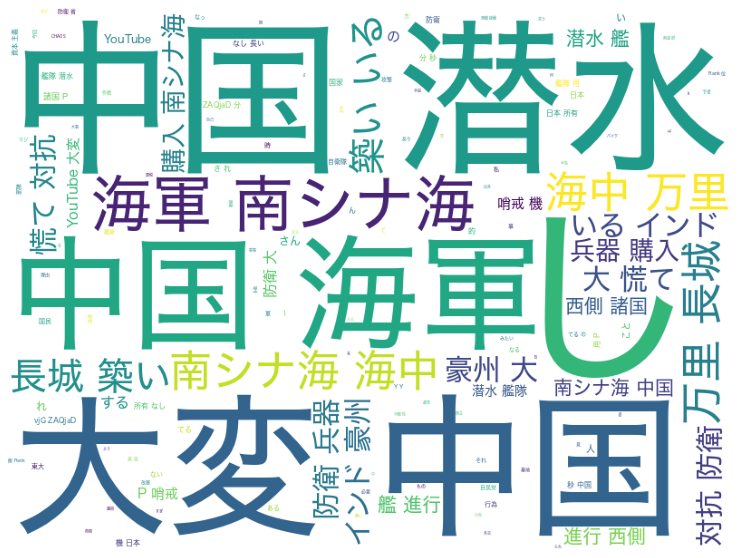

In [395]:
#wordcloudで出力するフォントを指定
font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W4.ttc"
txt = " ".join(words)

# ストップワードの設定(特定のワードは入らないように設定)
stop_words = ['https', 't', 'co',  'RT']

#解析した単語、ストップワードを設定、背景の色は白
wordcloud = WordCloud(background_color="white", font_path=font_path, stopwords=set(stop_words),
    width=800,height=600).generate(txt)

fig = plt.figure(figsize=(30, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## ポジ・ネガ分析

In [371]:
analyzer = oseti.Analyzer()
print(analyzer.analyze_detail("最後まで希望を捨てちゃいかん。あきらめたら、そこで試合終了だよ。"))
print(analyzer.analyze_detail("認めたくないものだな。自分自身の、若さゆえの過ちというものを。"))

[{'positive': ['活躍', '期待'], 'negative': [], 'score': 1.0}]
[{'positive': [], 'negative': ['認める-NEGATION'], 'score': -1.0}, {'positive': ['若い'], 'negative': ['過ち'], 'score': 0.0}]


In [396]:
ave_senti = []
for tweet in df['full_text']:
    print(tweet)
    senti = analyzer.analyze(tweet)
    print(analyzer.analyze_detail(tweet), np.mean(senti))
    ave_senti.append(np.mean(senti))
ave_senti

【大変だ！『中国海軍が南シナ海に「海中万里の長城」を築いている！』インド・豪州大慌てで対抗防衛兵器購入！】南シナ海で中国潜水艦が大進行！西側諸国... https://t.co/CKFt50gGip @YouTubeより
[{'positive': [], 'negative': ['大変'], 'score': -1.0}, {'positive': [], 'negative': ['慌てる', '対抗'], 'score': -1.0}, {'positive': [], 'negative': [], 'score': 0.0}, {'positive': [], 'negative': [], 'score': 0.0}] -0.5
「諸人皆死して無間地獄に堕つること雨のごとくしげからん時、此の五字の大曼荼羅だらを身に帯し心に存ぜば、諸王は国を扶たすけ万民は難をのがれん」―防衛手段の最善を尽くしたとしても、仏法に背くならば、他国の侵略を防ぐことはできない　#顕正会 #国立戒壇　https://t.co/Wz5Vhvq9vD
[{'positive': ['死-NEGATION', '地獄-NEGATION', '難-NEGATION', '背く-NEGATION', '侵略-NEGATION'], 'negative': ['心-NEGATION', '手段-NEGATION', '最善-NEGATION', '防ぐ-NEGATION', '防ぐ こと は できる-NEGATION'], 'score': 0.0}] 0.0
@001AAAAAAAAA 3回も大事故起こして「自衛隊の事故でごちゃごちゃ言うな」ぐらいの主旨をホザく自衛隊基地害は、航空自衛隊小松基地周辺に皆無。つうかそういう発言が正論なら、防衛省、小松基地司令は胸を張って発言してくれやw国会で追求の案件上等!!#小松素人認定#自衛隊基地害 https://t.co/SjB0cdRQm5
[{'positive': [], 'negative': ['事故', '事故', 'ごちゃごちゃ', '害'], 'score': -1.0}, {'positive': ['正論'], 'negative': [], 'score': 1.0}, {'positive': ['上等', '認定'], 'n

[-0.5,
 0.0,
 0.0,
 -0.22222222222222224,
 0.5,
 -0.6,
 -0.5,
 -0.6,
 -0.42857142857142855,
 -0.5,
 0.2,
 0.16666666666666666,
 -0.4,
 -0.2857142857142857,
 0.1,
 -0.5,
 -0.16666666666666666,
 -0.22222222222222224,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.75,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.08333333333333333,
 -0.5,
 -0.5,
 -0.4,
 -0.6,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 1.0,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.25,
 -0.5,
 -0.5,
 -0.5,
 -0.5,
 -0.3333333333333333,
 0.16666666666666669,
 -0.25,
 0.6666666666666666,
 -0.2,
 1.0,
 -1.0,
 0.0,
 -0.33333333333333337,
 0.0,
 0.0,
 0.75,
 -0.7142857142857143,
 -0.11111111111111112,
 0.0,
 0.6666666666666666,
 -0.2857142857142857,
 -0.20000000000000004,
 -1.0,
 0.16666666666666666,
 0.6666666666666666,
 0.5,
 0.0,
 -0.5,
 0.0,
 0.0,
 0.14285714285714285,
 0.0,
 -0.08333333333333331,
 0.0,
 0.5,
 -0.2,
 0.0,
 -0.3333333333333333,
 1.0,
 0.6666666666666666,
 -0.6666666666666666,
 -0.5,
 0.6666666666666666,
 -0.125,
 0.0,
 -1.0,
 

([<matplotlib.patches.Wedge at 0x15f91e910>,
 [Text(0.30689022851116454, 1.056323050796661, 'ネガ'),
  Text(0.8251221330042984, -0.7274431012982646, 'ややネガ'),
  Text(-1.0999999999999954, 1.0298943258065002e-07, 'ややポジ'),
  Text(-0.46835712939770585, 0.9953098006863695, 'ポジ')])

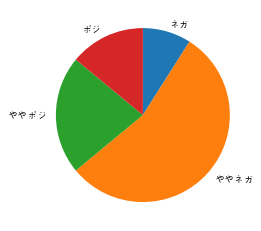

In [397]:
hist, bins = np.histogram(ave_senti, bins=4)
plt.rcParams['font.family'] = "AppleGothic"
plt.pie(hist, labels=['ネガ', 'ややネガ', 'ややポジ', 'ポジ'], counterclock=False, startangle=90)

## 感情分析（Transformer 版）

In [340]:
!pip install transformers fugashi ipadic

     |████████████████████████████████| 3.1 MB 3.9 MB/s            
     |████████████████████████████████| 285 kB 3.8 MB/s            
     |████████████████████████████████| 13.4 MB 7.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 197 kB 4.2 MB/s            
     |████████████████████████████████| 288 kB 5.5 MB/s            
     |████████████████████████████████| 895 kB 7.8 MB/s            
     |████████████████████████████████| 2.2 MB 5.5 MB/s            
     |████████████████████████████████| 76 kB 3.8 MB/s             
     |████████████████████████████████| 59 kB 3.5 MB/s             
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556723 sha256=155697c6bde8fb56bcd4345db20d9bf525cb73d2c9b1169ea0939049f00e7b12
  Stored in directory: /Users/hsato/Library/Caches/pip/wheels/a0/9e/13/a63ab80684c3bd6305fe2bded26ac5f2c72ee1cb07a747994d
Successfully built ipadic


In [341]:
from transformers import pipeline 
from transformers import AutoModelForSequenceClassification 
from transformers import BertJapaneseTokenizer 

In [342]:
model = AutoModelForSequenceClassification.from_pretrained('daigo/bert-base-japanese-sentiment') 
tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking') 
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer) 

Downloading: 100%|██████████| 1.29k/1.29k [00:00<00:00, 285kB/s]
Downloading: 100%|██████████| 422M/422M [01:49<00:00, 4.06MB/s]
Downloading: 100%|██████████| 252k/252k [00:00<00:00, 376kB/s]
Downloading: 100%|██████████| 479/479 [00:00<00:00, 235kB/s]


In [357]:
print(nlp("最後まで希望を捨てちゃいかん。あきらめたら、そこで試合終了だよ。"))
print(nlp("認めたくないものだな。自分自身の、若さゆえの過ちというものを。"))

[{'label': 'ポジティブ', 'score': 0.6421804428100586}]
[{'label': 'ネガティブ', 'score': 0.8296632170677185}]


In [370]:
sentiments = []
for tweet in df['full_text']:
    print(tweet)
    senti = nlp(tweet)
    print(senti)
    sentiments.append(senti[0]['score'])
print(sentiments)
print(np.mean(sentiments))

@jijicom https://t.co/3lp6XON0oV海上保安官には、刑法や国際法を含む法学の素養「も」要求される。(by 法学部卒。)ちなみに、#防大 は文系の学生にも、狭いながらも門戸を開いている(by 高校の某同級生(文系)が防大に進んだ)。
[{'label': 'ポジティブ', 'score': 0.8955623507499695}]
#横須賀 #防大 令和3年度防衛大学校開校祭に伴うジェット機の飛行予定について（2021年11月4日）https://t.co/UBO0Xex44ohttps://t.co/yjaWlaiUb8 https://t.co/1jWhPmyLKA
[{'label': 'ポジティブ', 'score': 0.8555366396903992}]
#横須賀 #浦賀 #防大 浦賀駅で1学年生を呼び止めて開校祭について質問しだが、やはり家族のみ招待で一般公開は無いとの事。呼び止めた時に何事かと引かれてしまったorz浦賀駅で降りたという事はあの山の中の急階段を上がるか南からの坂を登るんだな。
[{'label': 'ポジティブ', 'score': 0.8258422017097473}]
めっちゃ緊張する！#防衛大学校#防大#防衛大学校入試#入試#大学入試
[{'label': 'ポジティブ', 'score': 0.8912304043769836}]
今日も１日お疲れ様でした(*´ω｀*)寒いので早く帰ってぬくぬくして下さい🍲　　♪  　　♪　∧＿∧  　　　 ∩´･ω･`)  　　ｶｴﾘﾏｼｮ～♪　　　　ヽ　 ⊂ノ  　　　 (( （　 ⌒)　　))  　　　　　　c し'#おつかれさま #自衛隊 #千葉 週末は #防大（一般）１次試験💪🏼
[{'label': 'ポジティブ', 'score': 0.9123213887214661}]
🆕#防大　ﾊﾞｰﾁｬﾙｵｰﾌﾟﾝｷｬﾝﾊﾟｽにコンテンツを追加しました🌟地球海洋学科の教授による「極端気象から身を守る」をテーマにオンライン講義動画を公開しました☁ぜひご覧ください📺https://t.co/xZtb7cY9E4#夢ナビ　#雲を掴む　#研究
[{'label': 'ポジティブ', 'score': 0.9070906043052673}]
[0.8955623507

## 課題
各自のテーマで Tweet を分析せよ。